# Popular, Lift, ImplicitMF, and ItemItem with implifict feedback

## Run first few cells below if running on Google Colab

In [ ]:
!pip install lenskit~=0.14


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: C:\Users\nguye\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
from google.colab import drive

# connect to Drive files
drive.mount("/content/drive")

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
%cd "/content/drive/MyDrive/DSCI 641: Project"

/content/drive/.shortcut-targets-by-id/1vTlNOLkXqrswcYl880GzIv4H0GuJjhWH/DSCI 641: Project


## Import Libraries

In [ ]:
# Built-in Python libraries
from pathlib import Path
import logging
import sys
from typing import Tuple, List, Dict
import os

# PyData libraries
import pandas as pd
import numpy as np
import seaborn as sns

# LensKit libraries
from lenskit.datasets import MovieLens
import lenskit.crossfold as xf
from lenskit.algorithms import basic, bias, user_knn, item_knn, als, svd, ranking
from lenskit import Recommender, topn, batch, util, Predictor
from lenskit.metrics.predict import rmse
from lenskit.metrics.topn import ndcg

# Modules
from algorithms import lift

In [ ]:
from itertools import tee

In [ ]:
path = Path(".")

### Anime
* Useful to search up information (name, genre, number of episodes, etc) about an anime, given the ID

In [ ]:
anime_df = pd.read_csv(path / "dataset/2017" /"anime.csv")
anime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


In [ ]:
anime_df = anime_df.query("type != 'Music'").sort_values(by="members", ascending=False)

In [ ]:
ratings_df = pd.read_csv(path / "dataset/2017" / "rating.csv")
ratings_df = ratings_df.rename(columns={"user_id": "user", "anime_id": "item"})
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column  Dtype
---  ------  -----
 0   user    int64
 1   item    int64
 2   rating  int64
dtypes: int64(3)
memory usage: 178.8 MB


In [ ]:
# Path("data").mkdir(parents=True)

### Ratings

In [ ]:
train = pd.read_csv("data/train.csv").drop(columns=["Unnamed: 0"])
test = pd.read_csv("data/eval.csv").drop(columns=["Unnamed: 0"])

Wrap the instance in a recommender and fit the algorithm on training data

In [ ]:
def fit_the_model(
    algo: Predictor,
    train: pd.DataFrame,
) -> ranking.TopN:
    fittable = util.clone(algo)
    fittable = Recommender.adapt(fittable)
    fittable.fit(train)
    return fittable

Generates 20 recommendations per user

In [ ]:
def make_recommendations(
    aname: str,
    algo: Predictor,
    train: pd.DataFrame,
    test: pd.DataFrame,
) -> pd.DataFrame:
    fittable = fit_the_model(
        algo=algo,
        train=train,
    )
    users = test.user.unique()
    recs = batch.recommend(fittable, users, 20) # change to 10, if results aren't doing well, do 20.
    recs["algorithm"] = aname
    return recs

Creates instances for all algorithms

In [ ]:
popular_model = basic.Popular()
lift_model = lift.Lift()
implicit_mf_model = als.ImplicitMF(50)
item_item_sum_model = item_knn.ItemItem(20, 2, feedback='implicit')

In [ ]:
rla = topn.RecListAnalysis()
rla.add_metric(topn.ndcg)
rla.add_metric(topn.hit)

Generates recommendations for the Popular algorithm and computes metrics

In [ ]:
popular_rec = make_recommendations(
    aname="Popular",
    algo=popular_model,
    train=train,
    test=test
)

popular_rec.to_parquet("data/output/popular-rec-20.parquet", index=False)

popular_results = rla.compute(popular_rec, test)

Generates recommendations for the Lift algorithm and computes metrics

In [ ]:
lift_rec = make_recommendations(
    aname="Lift",
    algo=lift_model,
    train=train,
    test=test
)

lift_rec.to_parquet("data/output/lift-rec-20.parquet", index=False)

lift_results = rla.compute(lift_rec, test)

  0%|          | 0/10 [00:00<?, ?it/s]

Generates recommendations for the ImplicitMF algorithm and computes metrics

In [ ]:
implicit_mf_rec = make_recommendations(
    aname="ImplicitMF",
    algo=implicit_mf_model,
    train=train,
    test=test
)

implicit_mf_rec.to_parquet("data/output/implicit-mf-rec-20.parquet", index=False)

implicit_mf_results = rla.compute(implicit_mf_rec, test)

Numba is using threading layer omp - consider TBB
found 1 potential runtime problems - see https://boi.st/lkpy-perf


Generates recommendations for the ItemItem algorithm with Implicit Feedback and computes metrics

In [ ]:
item_item_sum_rec = make_recommendations(
    aname="ItemItemSum",
    algo=item_item_sum_model,
    train=train,
    test=test
)

item_item_sum_rec.to_parquet("data/output/item-item-sum-rec-20.parquet", index=False)

item_item_sum_results = rla.compute(item_item_sum_rec, test)

C:\Users\nguye\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\lenskit\algorithms\item_knn.py:119: NumbaTypeSafetyWarning: unsafe cast from uint64 to int64. Precision may be lost.
  b = blocks[bi]


Concatenates all results to generate bar chart

In [ ]:
results = pd.concat([popular_results, lift_results, implicit_mf_results, item_item_sum_results])

results

nrecs      ndcg  hit
algorithm   user                       
Popular     3         20  0.155937  1.0
            8         20  0.000000  0.0
            12        20  0.225592  1.0
            18        20  0.291931  1.0
            19        20  0.186614  1.0
...                  ...       ...  ...
ItemItemSum 73487     20  0.000000  0.0
            73489     20  0.000000  0.0
            73499     20  0.221396  1.0
            73510     20  0.170284  1.0
            73515     20  0.143749  1.0

[69488 rows x 3 columns]

Calculates the mean hit rate for each algorithm and plots it for each algorithm

<AxesSubplot: title={'center': 'Hit Rate of Recommendations'}, xlabel='algorithm'>

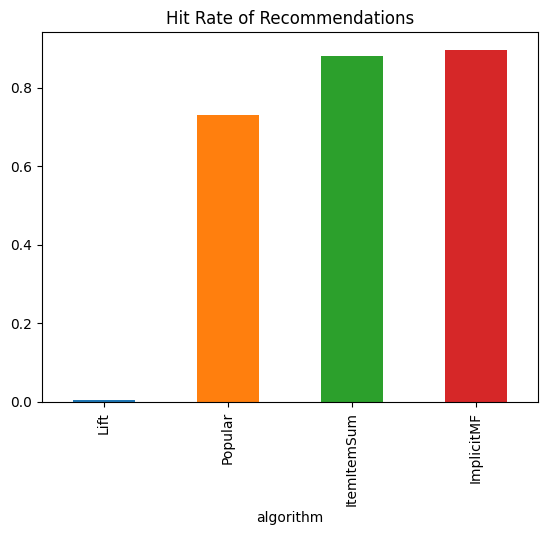

In [ ]:
# Assuming 'results' already contains the hit metric evaluations
hit_results = (
    results
    .groupby('algorithm')
    .hit.mean()
    .sort_values()
)

hit_results.plot.bar(color=sns.color_palette(), title="Hit Rate of Recommendations")

Calculates the mean nDCG rate for each algorithm and plots it for each algorithm

<AxesSubplot: title={'center': 'nDCG of Recommendations'}, xlabel='algorithm'>

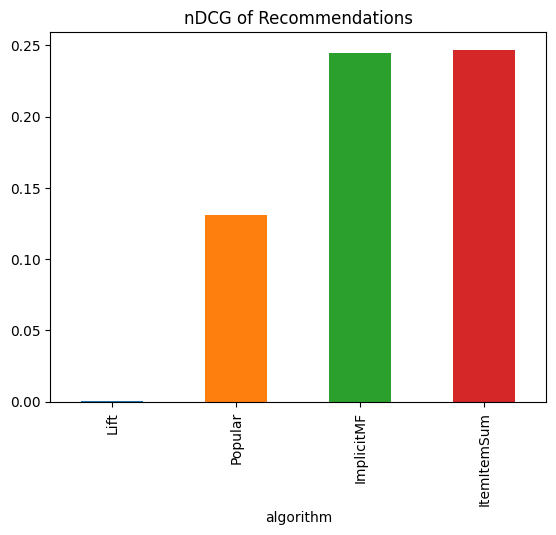

In [ ]:
(
    results
    .groupby('algorithm')
    .ndcg.mean()
    .sort_values()
    .plot.bar(color=sns.color_palette(), title="nDCG of Recommendations")
)

In [ ]:
results.groupby('algorithm').hit.mean()

algorithm
ImplicitMF     0.896846
ItemItemSum    0.881706
Lift           0.003339
Popular        0.730774
Name: hit, dtype: float32